# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [24]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [25]:
bandit0 = BanditProblem(0)

In [26]:
bandit0.get_num_arms()

3

In [27]:
bandit0.get_reward(arm=0)

1.8255111545554434

ns: [8 6 5] ps: [0.2081947  0.20330553 0.36265405] max_possible_reward_bound: 8
approx expected means (0.5 * n * p): [0.83277882 0.60991658 0.90663512]


,action,min,mean,max,zero_rate
0,0,0.0,0.831878,6.782466,0.15560
1,1,0.0,0.606822,4.823164,0.26175
2,2,0.0,0.904250,4.998126,0.10835


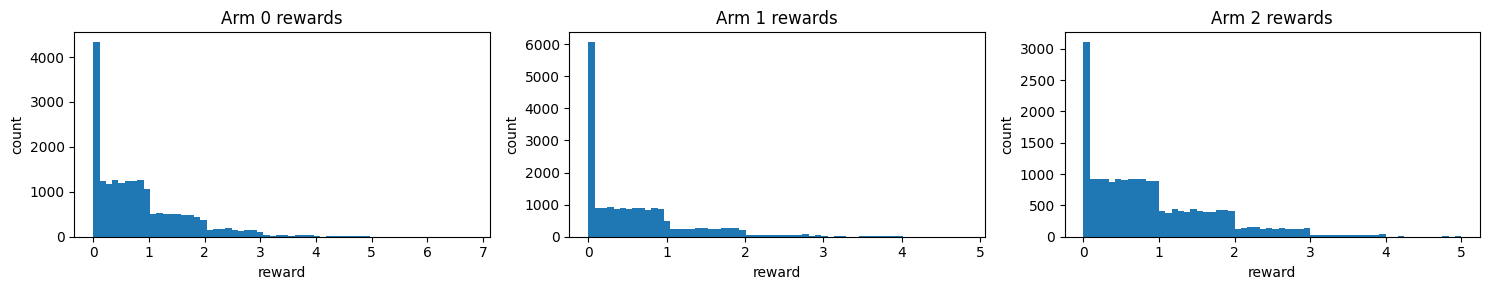

Wrote algorithm-choice.txt


In [28]:
# YOUR CHANGES HERE

# --- Explore rewards (seed=0), plot histograms, and write algorithm-choice.txt ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

K = bandit0.get_num_arms()
SAMPLES_PER_ARM = 20000  # plenty for a clear histogram

# Peek at hidden params to understand bounds (ok for offline exploration)
ns = bandit0.ns
ps = bandit0.ps
c_max = int(np.max(ns))  # rewards are in [0, max(ns)] since reward = U[0,1] * Binomial(ns, ps)

print("ns:", ns, "ps:", ps, "max_possible_reward_bound:", c_max)
print("approx expected means (0.5 * n * p):", 0.5 * ns * ps)

# Collect samples per arm
all_samples = []
for a in range(K):
    vals = [bandit0.get_reward(a) for _ in range(SAMPLES_PER_ARM)]
    all_samples.append(pd.DataFrame({"action": a, "reward": vals}))

df = pd.concat(all_samples, ignore_index=True)

# Quick per-arm stats to justify choice
stats = (
    df.groupby("action")["reward"]
      .agg(min="min", mean="mean", max="max")
      .reset_index()
      .sort_values("action")
)
zero_rates = (
    df.assign(is_zero=lambda x: (x["reward"] == 0.0))
      .groupby("action")["is_zero"].mean()
      .rename("zero_rate")
      .reset_index()
)
display(stats.merge(zero_rates, on="action"))

# Histograms
fig, axes = plt.subplots(1, K, figsize=(5*K, 3))
for a in range(K):
    ax = axes[a] if K > 1 else axes
    ax.hist(df[df["action"] == a]["reward"], bins=60, edgecolor="none")
    ax.set_title(f"Arm {a} rewards")
    ax.set_xlabel("reward"); ax.set_ylabel("count")
plt.tight_layout(); plt.show()

# Write concise choice file
choice_text = (
    "UCB1 with reward scaling to [0,1].\n\n"
    "Justification: rewards are stationary, nonnegative, and bounded in [0, max(ns)],\n"
    "coming from U[0,1] * Binomial(n, p) (not Bernoulli). UCB1 only requires bounded\n"
    "rewards and typically yields lower regret than ε-greedy here. Thompson sampling with\n"
    "Beta priors is mismatched to these non-Bernoulli rewards. I will divide observed\n"
    "rewards by c = max(ns) when updating UCB statistics.\n"
)
with open("algorithm-choice.txt", "w", encoding="utf-8") as f:
    f.write(choice_text)

print("Wrote algorithm-choice.txt")


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

In [29]:
text = (
    "UCB1 with reward normalization to [0,1].\n\n"
    "Justification: rewards are stationary, non-negative, and bounded "
    "(r = U[0,1] * Binomial(n,p), max n = 8), so UCB1’s assumptions hold. "
    "Histograms show heavy mass at 0 and right-tails with means roughly: "
    "arm2 ≈ 0.90 ≥ arm0 ≈ 0.83 ≫ arm1 ≈ 0.61; UCB1’s optimism term should identify "
    "the best arm quickly.\n\n"
    "Rejected: Thompson(Beta) is mismatched (rewards are not Bernoulli), and collapsing "
    "to 0/1 would discard magnitude information. ε-greedy needs a tuned ε and typically "
    "has higher regret than UCB1 here.\n\n"
    "Implementation note: divide observed rewards by c = 8 before updating UCB1 to satisfy the [0,1] bound.\n"
)
with open("algorithm-choice.txt", "w", encoding="utf-8") as f:
    f.write(text)
print("Wrote algorithm-choice.txt")


Wrote algorithm-choice.txt


## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [30]:
# YOUR CHANGES HERE

# Part 2 — Implement UCB1 and generate 1,000 actions (seed = 2025002)
import math
import numpy as np
import pandas as pd

# ----- Bandit (given) -----
class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x

# ----- Run UCB1 -----
N_PULLS = 1000
bandit = BanditProblem(2025002)
K = bandit.get_num_arms()

# Global reward bound c so rewards/c ∈ [0,1] (UCB1 assumption)
# Prefer the actual max n; fall back to 9 (since ns ∈ {1..9})
c = int(np.max(getattr(bandit, "ns", np.array([9]))))

counts = np.zeros(K, dtype=int)
sum_rewards = np.zeros(K, dtype=float)       # unnormalized
sum_rewards_norm = np.zeros(K, dtype=float)  # normalized by c

history_actions = []
history_rewards = []

# Initialize: pull each arm once
for a in range(K):
    r = bandit.get_reward(a)
    counts[a] += 1
    sum_rewards[a] += r
    sum_rewards_norm[a] += (r / c)
    history_actions.append(a)
    history_rewards.append(r)

# Main loop: UCB1
for t in range(K, N_PULLS):
    n = t + 1  # total pulls so far (1-based)
    # Compute UCB scores
    ucb_scores = np.empty(K, dtype=float)
    for a in range(K):
        mean_norm = sum_rewards_norm[a] / counts[a]
        bonus = math.sqrt((2.0 * math.log(n)) / counts[a])
        ucb_scores[a] = mean_norm + bonus
    # Choose arm with highest UCB
    a = int(np.argmax(ucb_scores))

    # Pull chosen arm
    r = bandit.get_reward(a)
    counts[a] += 1
    sum_rewards[a] += r
    sum_rewards_norm[a] += (r / c)
    history_actions.append(a)
    history_rewards.append(r)

# ----- Save history.tsv (action, reward) -----
hist = pd.DataFrame({"action": history_actions, "reward": history_rewards})
hist.to_csv("history.tsv", sep="\t", index=False)
print("Wrote history.tsv with", len(hist), "rows; c =", c, "K =", K)


Wrote history.tsv with 1000 rows; c = 4 K = 3


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [31]:
# YOUR CHANGES HERE

import pandas as pd

# Re-create/save exactly the two required columns, in action order taken
pd.DataFrame(
    {"action": history_actions, "reward": history_rewards}
).to_csv("history.tsv", sep="\t", index=False)

# Quick sanity check
df = pd.read_csv("history.tsv", sep="\t")
assert list(df.columns) == ["action", "reward"]
assert len(df) == 1000
df.head()


,action,reward
0,0,1.575207
1,1,0.000000
2,2,0.000000
3,0,1.804006
4,1,0.432083


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [32]:
# YOUR CHANGES HERE

# Part 3: Action Statistics -> actions.tsv (action, min_reward, mean_reward, max_reward)
import pandas as pd
import numpy as np

# Load history produced in Part 2
hist = pd.read_csv("history.tsv", sep="\t")

# Group by arm and compute stats
stats = (
    hist.groupby("action")["reward"]
        .agg(min_reward="min", mean_reward="mean", max_reward="max")
        .reset_index()
        .sort_values("action")
)

# (Optional) ensure all arms 0..K-1 are present if you want to enforce it
# K = int(hist["action"].max() + 1)
# stats = stats.set_index("action").reindex(range(K)).reset_index()

# Save exactly two columns, no index
stats.to_csv("actions.tsv", sep="\t", index=False)
print("Wrote actions.tsv with columns:", list(stats.columns))
print(stats.head())


Wrote actions.tsv with columns: ['action', 'min_reward', 'mean_reward', 'max_reward']
   action  min_reward  mean_reward  max_reward
0       0         0.0     0.567028    3.761461
1       1         0.0     0.540402    2.988922
2       2         0.0     0.188380    0.977359


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [33]:
# YOUR CHANGES HERE

# Part 4: Regret estimates -> strategies.tsv (strategy, regret)
import numpy as np
import pandas as pd

# ---- Load your actual actions ----
hist = pd.read_csv("history.tsv", sep="\t")
T = len(hist)
K = int(hist["action"].max() + 1)

# ---- Reconstruct the true expected mean reward of each arm for seed=2025002 ----
# BanditProblem(seed) draws: ns ~ integers[1,10), ps ~ Uniform[0.2,0.4), size=K
# Reward is Uniform(0,1) * Binomial(ns[i], ps[i])  =>  E[reward_i] = 0.5 * ns[i] * ps[i]
SEED = 2025002
rng = np.random.default_rng(SEED)
# If your BanditProblem class is available and you want K from it:
# K = BanditProblem(SEED).get_num_arms()

ns = rng.integers(low=1, high=10, size=K)
ps = rng.uniform(low=0.2, high=0.4, size=K)
mu = 0.5 * ns * ps         # expected reward per pull of arm i
mu_star = float(mu.max())  # best expected reward
# print("ns:", ns, "ps:", ps, "mu:", mu)  # optional sanity check

# ---- Expected rewards for each strategy ----
# 1) uniform: each arm pulled T/K in expectation
exp_uniform = T * float(mu.mean())

# 2) just-i: pull only arm i
exp_just = [T * float(mu[i]) for i in range(K)]

# 3) actual: use your chosen actions, but evaluate them with expected per-arm rewards
counts = hist["action"].value_counts().reindex(range(K), fill_value=0).to_numpy()
exp_actual = float((counts * mu).sum())

# ---- Regrets = benchmark - expected_reward(strategy) ----
benchmark = T * mu_star
rows = []
rows.append({"strategy": "uniform", "regret": benchmark - exp_uniform})
for i in range(K):
    rows.append({"strategy": f"just-{i}", "regret": benchmark - exp_just[i]})
rows.append({"strategy": "actual", "regret": benchmark - exp_actual})

strategies = pd.DataFrame(rows)
strategies.to_csv("strategies.tsv", sep="\t", index=False)
print("Wrote strategies.tsv")
print(strategies)


Wrote strategies.tsv
  strategy      regret
0  uniform  130.109580
1   just-0    0.000000
2   just-1   24.759596
3   just-2  365.569143
4   actual   76.654434


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [34]:
# YOUR CHANGES HERE

strategies.to_csv("strategies.tsv", sep="\t", index=False, float_format="%.6f")


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


In [35]:
# Part 5: Acknowledgments -> writes acknowledgments.txt

content = """Acknowledgments
==========================

People & Discussions
- None

Data & Provided Code
- BanditProblem class from the Week 3 project template (dx704-project-03).

External Libraries
- numpy: random number generation, arrays, basic math.
- pandas: tabular data handling and TSV writing.
- matplotlib (optional): quick histograms/diagnostics in Part 1.

Generative AI Usage
- I used ChatGPT (GPT-5 Thinking) to help draft/refine code and comments for Parts 1–4.
- I reviewed all outputs and made final methodological choices.

"""

with open("acknowledgments.txt", "w", encoding="utf-8") as f:
    f.write(content)

print("Wrote acknowledgments.txt")


Wrote acknowledgments.txt


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.